In [20]:
# pip install sdv
# pip3 install torch torchvision torchaudio
# pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
# pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

In [1]:
# LIBRARIES ~
import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

from sdv import SDV # https://sdv.dev/SDV/getting_started/quickstart.html
from sdv.tabular import GaussianCopula


from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, PrecisionRecallDisplay

# Setting
pd.set_option('display.max_columns', 500)

C:\Users\dmariani\.conda\envs\SDV\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# HOME DIRECTORY
dir_origin = os.getcwd(); print(dir_origin)
#print(os.listdir(os.getcwd()))

C:\Users\dmariani\OneDrive - BUSINESS INTEGRATION PARTNERS SPA\3 - Osservatorio\Syntetic Data Generation


# CASE STUDY

In [3]:
# INPUT PARAMETERS
FEATURE_COLUMNS = [
    'Type',
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]', 
    'Torque [Nm]',
    'Tool wear [min]'
]
LABEL_A = "Target"
LABEL_B = "Failure Type"

K_FOLDS = 5
TEST_SPLIT_SIZE = 0.25

# PERCENTAGE_ADDED_SYNTHETIC_DATA = 0.5 # +50% positive samples
PERCENTAGE_ADDED_SYNTHETIC_DATA = 1 # +100% positive samples

GENERATE_KWARGS = dict(
                        uniformization_ratio=0,
                        stretch_factor=1
)

SEED = 42

In [4]:
# LOAD 

dir_data = r'C:\Users\dmariani\OneDrive - BUSINESS INTEGRATION PARTNERS SPA\3 - Osservatorio\Syntetic Data Generation\input data'
os.chdir(dir_data); print(dir_data)

df_input = pd.read_csv("predictive_maintenance.csv")\
          .assign(Type=lambda x: LabelEncoder().fit_transform(x["Type"])) # Encoding numerico del campo categoriale "Type"

df_input.drop(columns=['UDI','Product ID','Failure Type'], inplace=True)

print(df_input.shape)
df_input.head()

C:\Users\dmariani\OneDrive - BUSINESS INTEGRATION PARTNERS SPA\3 - Osservatorio\Syntetic Data Generation\input data
(10000, 7)


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,298.1,308.6,1551,42.8,0,0
1,1,298.2,308.7,1408,46.3,3,0
2,1,298.1,308.5,1498,49.4,5,0
3,1,298.2,308.6,1433,39.5,7,0
4,1,298.2,308.7,1408,40.0,9,0


In [5]:
print('Target value count:')
df_input["Target"].value_counts()

Target value count:


0    9661
1     339
Name: Target, dtype: int64

# Generazione di Syntetic Data Values

In [6]:
# Instanza e training del modello di Syntetic Data Values sui soli valori target positivi
sdv = GaussianCopula()

ind = df_input['Target']==1
df = df_input.loc[ind,:]

sdv.fit(df)

sdv.sample(100) # sample 100 new rows

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,1,302.3,310.5,2387,6.5,91,1
1,2,298.1,308.4,2164,35.9,134,1
2,1,300.3,308.8,1499,54.4,0,1
3,1,297.3,309.1,1765,31.9,240,1
4,1,299.3,309.9,1677,58.3,36,1
...,...,...,...,...,...,...,...
95,1,301.5,311.4,1483,61.0,85,1
96,1,302.9,312.1,1226,70.7,149,1
97,2,301.6,310.4,1398,46.0,178,1
98,0,299.4,309.9,1451,39.6,231,1


# Modello RandomForestClassifier BASE

In [60]:
# Data
df = df_input.copy()
print(df.shape ,'base dataset')
print((df['Target']==1).sum(),'n° of failure') 

# Split
df_train, df_test = train_test_split(df, test_size=TEST_SPLIT_SIZE, train_size=1-TEST_SPLIT_SIZE, random_state=SEED, stratify=df['Target'])
print(TEST_SPLIT_SIZE*100,'% for test dataset')

(10000, 7) base dataset
339 n° of failure
25.0 % for test dataset


In [61]:
# Datasets
X_train_base=df_train.drop(columns='Target')
Y_train_base=df_train['Target']
print(X_train_base.shape, 'train dataset')

X_test_base=df_test.drop(columns='Target')
Y_test_base=pd.DataFrame(df_test['Target'])
print(X_test_base.shape, 'test dataset')

(7500, 6) train dataset
(2500, 6) test dataset


In [63]:
# MODEL 
model_base=RandomForestClassifier(n_estimators=20, max_depth=10, random_state=SEED, n_jobs=-1)
model_base.fit(X_train_base, Y_train_base)
    
# PREDICTION
Y_test_base['pred'] =       pd.DataFrame( model_base.predict(       X_test_base ) ).values
Y_test_base['pred_proba'] = pd.DataFrame( model_base.predict_proba( X_test_base ) ).iloc[:,1].values
Y_test_base.head()

# PERFORMANCE
print(f1_score(       Y_test_base['Target'], Y_test_base['pred']), 'f1 score')
print(precision_score(Y_test_base['Target'], Y_test_base['pred']), 'precision')
print(recall_score(   Y_test_base['Target'], Y_test_base['pred']), 'recall')

0.626865671641791 f1 score
0.8571428571428571 precision
0.49411764705882355 recall


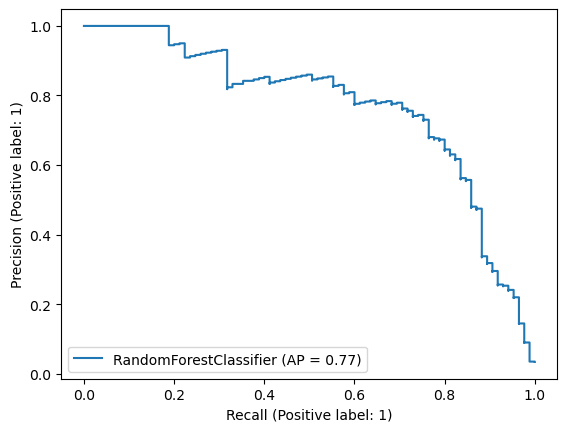

In [64]:
PrecisionRecallDisplay.from_estimator(model_base, X_test_base, Y_test_base['Target'])

In [65]:
# Sensitivity to seed parameter
SEEDS=range(0,10,1)
l_f1=[]
for seed in SEEDS:
    
    # MODEL 
    model_base=RandomForestClassifier(n_estimators=20, max_depth=10, random_state=seed, n_jobs=-1)
    model_base.fit(X_train_base, Y_train_base)
    
    # PREDICTION
    Y_test_base['pred'] =       pd.DataFrame( model_base.predict(       X_test_base ) ).values
    Y_test_base['pred_proba'] = pd.DataFrame( model_base.predict_proba( X_test_base ) ).iloc[:,1].values

    # PERFORMANCE
    l_f1.append( f1_score(Y_test_base['Target'], Y_test_base['pred']))

print(np.mean(l_f1), 'mean f1 on',len(SEEDS),'iteration')
l_f1

0.6407489987682355 mean f1 on 10 iteration


[0.6518518518518519,
 0.5925925925925927,
 0.6618705035971222,
 0.6618705035971222,
 0.6805555555555555,
 0.5909090909090908,
 0.6074074074074074,
 0.6370370370370371,
 0.6376811594202898,
 0.6857142857142856]

# # Modello RandomForestClassifier  con SDV

In [80]:
# Data
df = df_input.copy()
print(df.shape ,'base dataset')
print((df['Target']==1).sum(),'n° of failure') 

# Dataset split
df_train, df_test = train_test_split(df, test_size=TEST_SPLIT_SIZE, train_size=1-TEST_SPLIT_SIZE, random_state=SEED, stratify=df['Target'])
print(TEST_SPLIT_SIZE*100,'% for test dataset')

(10000, 7) base dataset
339 n° of failure
25.0 % for test dataset


In [81]:
# Enrichment of train dataset with only positive targets
df_sdv   = sdv.sample(int((df_train['Target']==1).sum()*PERCENTAGE_ADDED_SYNTHETIC_DATA))
df_train_enrich = pd.concat([df_train,df_sdv])

X_train=df_train_enrich.drop(columns='Target')
Y_train=df_train_enrich['Target']
print(X_train.shape, 'train dataset enriched with +', PERCENTAGE_ADDED_SYNTHETIC_DATA*100, '% positive targets:',df_sdv.shape[0])

X_test=df_test.drop(columns='Target')
Y_test=pd.DataFrame(df_test['Target'])
print(X_test.shape, 'test dataset')

(7754, 6) train dataset enriched with + 100 % positive targets: 254
(2500, 6) test dataset


In [82]:
# MODEL 
model_sdv=RandomForestClassifier(n_estimators=20, max_depth=10, random_state=SEED, n_jobs=-1)
model_sdv.fit(X_train, Y_train)

# PREDICTION
Y_test['pred'] =       pd.DataFrame( model_sdv.predict(       X_test ) ).values
Y_test['pred_proba'] = pd.DataFrame( model_sdv.predict_proba( X_test ) ).iloc[:,1].values

# PERFORMANCE
print(        f1_score(Y_test['Target'], Y_test['pred']),'f1')
print( precision_score(Y_test['Target'], Y_test['pred']),'precision')
print(    recall_score(Y_test['Target'], Y_test['pred']),'recall')

0.625 f1
0.7627118644067796 precision
0.5294117647058824 recall


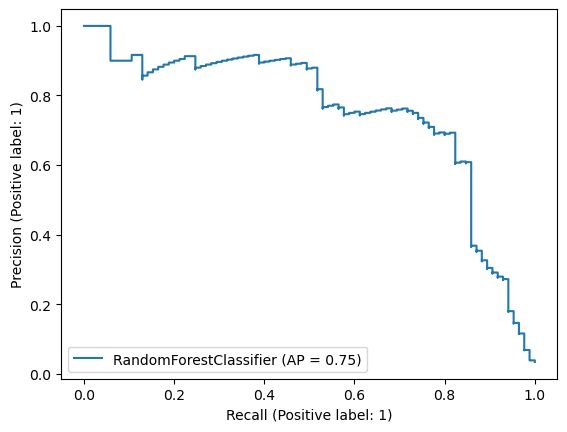

In [83]:
PrecisionRecallDisplay.from_estimator(model_sdv, X_test, Y_test['Target'])

In [84]:
# Sensitivity to seed parameter
SEEDS=list(range(0,10,1))+[SEED]
l_f1=[]
for seed in SEEDS:
#     print(seed,'seed')
    
    # MODEL 
    model_sdv=RandomForestClassifier(n_estimators=20, max_depth=10, random_state=seed, n_jobs=-1)
    model_sdv.fit(X_train, Y_train)
    
    # PREDICTION
    Y_test['pred'] =       pd.DataFrame( model_sdv.predict(       X_test ) ).values
    Y_test['pred_proba'] = pd.DataFrame( model_sdv.predict_proba( X_test ) ).iloc[:,1].values

    # PERFORMANCE
    l_f1.append( f1_score(Y_test['Target'], Y_test['pred']))

print(np.mean(l_f1), 'mean f1 on',len(SEEDS),'iteration')
l_f1

0.6682903210263172 mean f1 on 11 iteration


[0.7382550335570471,
 0.7333333333333334,
 0.6944444444444444,
 0.6099290780141845,
 0.7368421052631579,
 0.5757575757575757,
 0.6571428571428571,
 0.5970149253731343,
 0.6933333333333334,
 0.6901408450704225,
 0.625]

In [91]:
# Sensitivity to Enrichment parameter
ENRICH=[0.25,0.5,0.75,1,2,3,5,10]
l_f1=[]; l_precision=[]; l_recall=[]

for ii,ee in enumerate(ENRICH):
    
    # Enrichment of train dataset with only positive targets
    df_sdv   = sdv.sample(int((df_train['Target']==1).sum()*ee))
    df_train_enrich = pd.concat([df_train,df_sdv])

    X_train=df_train_enrich.drop(columns='Target')
    Y_train=df_train_enrich['Target']
    print(X_train.shape, 'train dataset enriched with +', ee*100, '% positive targets:',df_sdv.shape[0])

    X_test=df_test.drop(columns='Target')
    Y_test=pd.DataFrame(df_test['Target'])
#     print(X_test.shape, 'test dataset')

    # MODEL 
    model_sdv=RandomForestClassifier(n_estimators=20, max_depth=10, random_state=SEED, n_jobs=-1)
    model_sdv.fit(X_train, Y_train)

    # PREDICTION
    Y_test['pred'] =       pd.DataFrame( model_sdv.predict(       X_test ) ).values
    Y_test['pred_proba'] = pd.DataFrame( model_sdv.predict_proba( X_test ) ).iloc[:,1].values

    # PERFORMANCE
    l_f1.append(        f1_score(       Y_test['Target'], Y_test['pred']))
    l_precision.append( precision_score(Y_test['Target'], Y_test['pred']))
    l_recall.append(    recall_score(   Y_test['Target'], Y_test['pred']))
    
print('')
print(np.mean(l_precision), 'mean precision on',ii,'iteration')
print(np.mean(l_recall), 'mean recall on',ii,'iteration')
print(np.mean(l_f1), 'mean f1 on',ii,'iteration')
l_f1

(7563, 6) train dataset enriched with + 25.0 % positive targets: 63
(7627, 6) train dataset enriched with + 50.0 % positive targets: 127
(7690, 6) train dataset enriched with + 75.0 % positive targets: 190
(7754, 6) train dataset enriched with + 100 % positive targets: 254
(8008, 6) train dataset enriched with + 200 % positive targets: 508
(8262, 6) train dataset enriched with + 300 % positive targets: 762
(8770, 6) train dataset enriched with + 500 % positive targets: 1270
(10040, 6) train dataset enriched with + 1000 % positive targets: 2540

0.6971309823403167 mean precision on 7 iteration
0.4955882352941176 mean recall on 7 iteration
0.5666832390524308 mean f1 on 7 iteration


[0.5714285714285714,
 0.5909090909090908,
 0.5925925925925927,
 0.5384615384615384,
 0.5405405405405405,
 0.5714285714285715,
 0.5798816568047337,
 0.5482233502538071]